In [1]:
from bnn.data import test_train_data, category_examples
from bnn.util import open_pickle_file
from bnn.predict import predict_on_data

from keras import backend as K
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math

Using TensorFlow backend.


In [2]:
(train_images, _), (test_images, _) = cifar10.load_data()

In [3]:
(train_results, test_results) = open_pickle_file('predictions/resnet50_cifar10/results.p')

Unpickling file predictions/resnet50_cifar10/results.p


In [4]:
test_results[0]

{'aleatoric_uncertainty': 4.0053521e-05,
 'epistemic_uncertainty': 0.017782148,
 'is_correct': 1,
 'label': 3,
 'label_expanded': array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'logits_raw': array([ -3.53938103,  -2.06822634,  -0.46229768,  10.74455357,
         -1.08706129,   2.79307413,   0.40762943,  -2.71156502,
         -2.84579802,  -3.39058375], dtype=float32),
 'softmax': 3,
 'softmax_raw': array([  6.25730081e-07,   2.72459010e-06,   1.35752380e-05,
          9.99587953e-01,   7.26802045e-06,   3.51995695e-04,
          3.24005014e-05,   1.43186799e-06,   1.25200631e-06,
          7.26120618e-07], dtype=float32)}

In [5]:
categories = category_examples('cifar10')

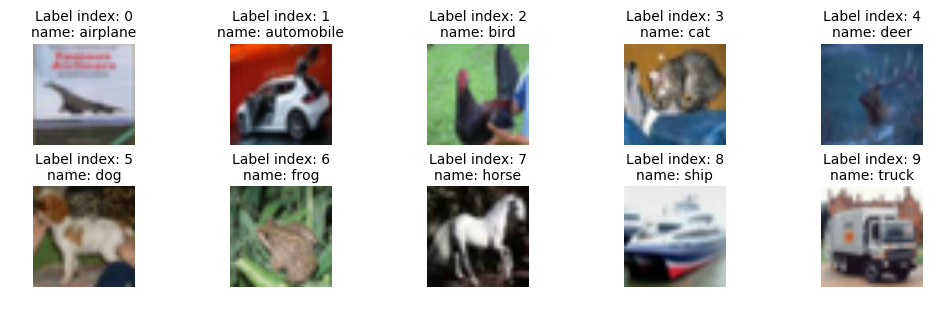

In [6]:
def display_categories(categories):
  f, axes = plt.subplots(int(len(categories)/5), 5, figsize=(10, 3))
  f.tight_layout()
  
  axes = np.reshape(axes, -1)
  
  for i in range(len(axes)):
    axes[i].imshow(categories[i]['example'])
    axes[i].set_title('Label index: ' + str(categories[i]['label']) +
    '\nname: '  + str(categories[i]['label_name']), fontsize=10)
    axes[i].axis('off')
  plt.savefig('blog_images/example_images.png')
  plt.show()
display_categories(categories)

In [7]:
def accuracy(results):
  return np.mean([x['is_correct'] for x in results])

print("train accuracy", accuracy(train_results))
print("test accuracy", accuracy(test_results))

train accuracy 0.98854
test accuracy 0.9255


In [8]:
def top_k_idx(arr, top_count):
  return np.argsort(arr, axis=1)[:, -top_count:]

def in_top(prediction, label):
  return label in prediction

def in_top_k(results, top_count):
  top_idx = top_k_idx([x['softmax_raw'] for x in results], top_count)
  labels = [x['label'] for x in results]
  return np.array([in_top(top_idx[i], labels[i]) for i in range(len(top_idx))])

def failure_idx(metrix_result):
  return np.nonzero(np.abs(metrix_result - 1))[0]

print("top 2 score train:", np.mean(in_top_k(train_results, 2).astype(int)))
top_2_failures = failure_idx(in_top_k(train_results, 2).astype(int))[0:6]
print("top 2 score test:", np.mean(in_top_k(test_results, 2).astype(int)))
top_2_failures_test = failure_idx(in_top_k(test_results, 2).astype(int))[0:6]

top 2 score train: 0.99912
top 2 score test: 0.9797


In [9]:
# average difference logit value
logits = [x['logits_raw'] for x in test_results]
max_logit_idx = np.argsort(logits, axis=1)[:,-1]
second_max_logit_idx = np.reshape(np.argsort(logits, axis=1)[:,-2:-1], -1)
max_logit = np.array([logits[i][max_logit_idx[i]] for i in range(len(max_logit_idx))])
second_max_logit = np.array([logits[i][second_max_logit_idx[i]] for i in range(len(second_max_logit_idx))])
np.mean(max_logit-second_max_logit)
# np.mean(np.max([x['logits_raw'] for x in train_results], axis=1))

def results_by_logit_position(results):
  num_classes = len(results[0]['logits_raw'])
  by_logit_position = [[] for _ in range(num_classes)]
  by_logit_position_idx = np.zeros((num_classes, len(results)))
  for i in range(len(results[0]['logits_raw'])):
    for r in range(len(results)):
      result = results[r]
      logit_position_idx = np.argsort(result['logits_raw'])[i]
      if logit_position_idx == result['label']:
        by_logit_position[i].append(result)
        by_logit_position_idx[i][r] = 1
        
  return by_logit_position, by_logit_position_idx

by_logit_position, by_logit_position_idx = results_by_logit_position(test_results)

for i in range(len(by_logit_position)):
  print(i, ":", len(by_logit_position[i]))
    

0 : 1
1 : 1
2 : 4
3 : 4
4 : 7
5 : 16
6 : 34
7 : 136
8 : 542
9 : 9255


In [10]:
def display_k(name, images, results, file_name=None):
  assert(len(images) == len(results))
  f, axes = plt.subplots(int(len(images)/2), 2, figsize=(10, 5))
  f.suptitle(name, fontsize=20)
  f.tight_layout()
  axes = np.reshape(axes, -1)
  
  for i in range(len(axes)):
    r = results[i]
    title_unformatted = "Aleatoric Uncertainty: {0:.4g}" \
    "   Epistemic Uncertainty: {1:.4g}" \
    "\nPredicted Label: {2:}" \
    "   Correct Label: {3:}"
    title = title_unformatted.format(r['aleatoric_uncertainty'],
                      r['epistemic_uncertainty'],
                      categories[r['softmax']]['label_name'],
                      categories[r['label']]['label_name'])
    axes[i].imshow(images[i])
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')
  plt.subplots_adjust(top=0.85)
  if file_name is not None:
    plt.savefig(file_name)
  plt.show()


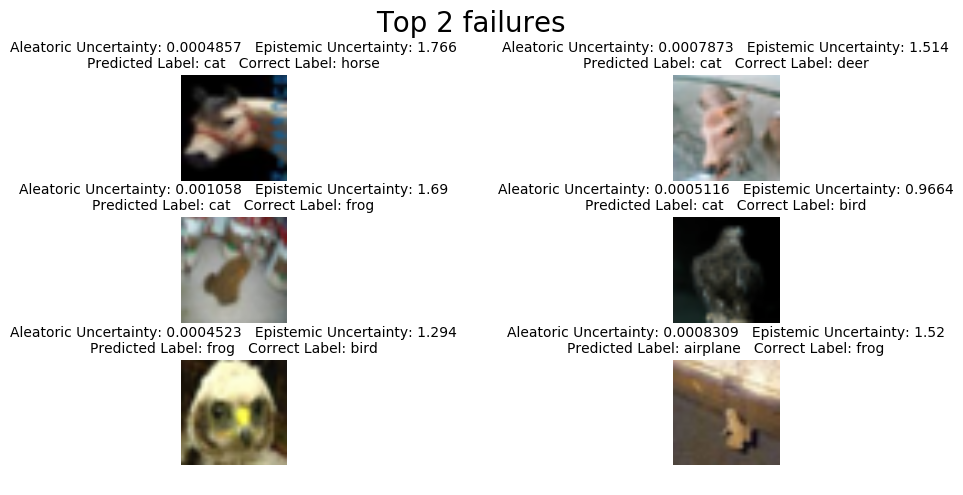

In [11]:
display_k("Top 2 failures", 
          test_images[top_2_failures_test], 
          [test_results[i] for i in top_2_failures_test])

In [12]:
max_epistemic_uncertainty_test = np.argsort([x['epistemic_uncertainty'] for x in test_results])[-8:]
max_aleatoric_uncertainty_test = np.argsort([x['aleatoric_uncertainty'] for x in test_results])[-8:]

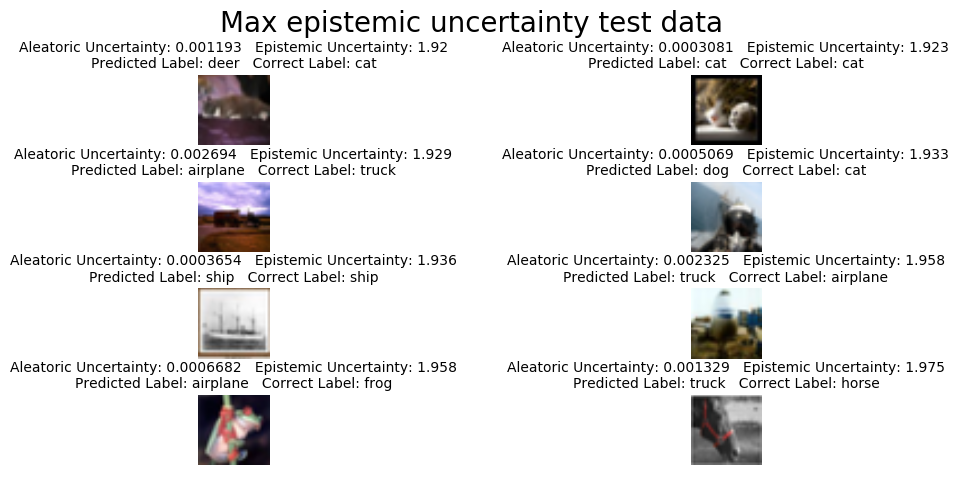

In [13]:
display_k("Max epistemic uncertainty test data", test_images[max_epistemic_uncertainty_test], 
          [test_results[i] for i in max_epistemic_uncertainty_test], file_name="blog_images/max_epistemic_uncertainty_test.png")

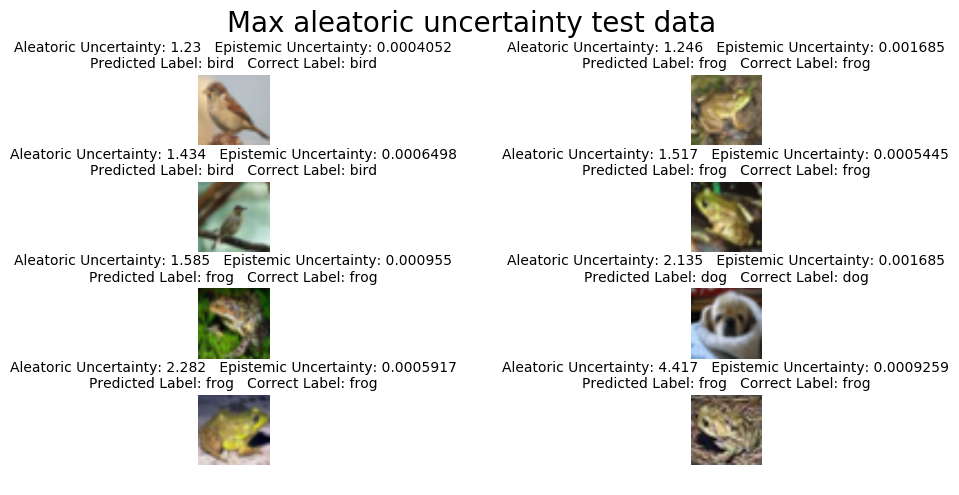

In [14]:
display_k("Max aleatoric uncertainty test data", test_images[max_aleatoric_uncertainty_test], 
          [test_results[i] for i in max_aleatoric_uncertainty_test], file_name="blog_images/max_aleatoric_uncertainty_test.png")

In [15]:
def stats(name, results):
  return [name, np.max(results),np.min(results),np.mean(results),np.std(results)]

def build_dataframe(rows):
  return pd.DataFrame(data=rows, columns=['type', 'max', 'min', 'mean', 'std'])

def stats_df(results, keys):
  rows = []
  for key in keys:
    rows.append(stats(key, [x[key] for x in results]))
  return build_dataframe(rows)

test_stats = stats_df(test_results, ['aleatoric_uncertainty', 'epistemic_uncertainty'])
test_stats

,type,max,min,mean,std
0,aleatoric_uncertainty,4.416725,0.000013,0.009055,0.074516
1,epistemic_uncertainty,1.974792,0.000173,0.403410,0.439121


In [16]:
def right_wrong(results):
  right = [x for x in results if x['is_correct']]
  wrong = [x for x in results if x['is_correct'] == False]
  
  return (right, wrong)

def join_df(dfs):  
  result = pd.DataFrame(columns=dfs[0][0].columns)
  for i in range(len(dfs[0][0])):
    for df in dfs:
      df[0].iloc[i, 0] = df[1] + '_' + df[0].iloc[i, 0]
      result = result.append(df[0].iloc[i])
    
  return result

In [17]:
(right_train, wrong_train) = right_wrong(train_results)
(right_test, wrong_test) = right_wrong(test_results)

In [18]:
first_position = stats_df(by_logit_position[-1], ['aleatoric_uncertainty', 'epistemic_uncertainty'])
second_position = stats_df(by_logit_position[-2], ['aleatoric_uncertainty', 'epistemic_uncertainty'])
third_position = stats_df(by_logit_position[-3], ['aleatoric_uncertainty', 'epistemic_uncertainty'])
rest_positions = stats_df(np.concatenate(by_logit_position[0:-3]), ['aleatoric_uncertainty', 'epistemic_uncertainty'])

In [19]:
right_test_stats = stats_df(right_test, ['aleatoric_uncertainty', 'epistemic_uncertainty'])
wrong_test_stats = stats_df(wrong_test, ['aleatoric_uncertainty', 'epistemic_uncertainty'])

test_right_wrong_stats = join_df([(right_test_stats, 'right'), (wrong_test_stats, 'wrong')])
test_right_wrong_stats

,type,max,min,mean,std
0,right_aleatoric_uncertainty,4.416725,0.000013,0.009705,0.077419
0,wrong_aleatoric_uncertainty,0.015610,0.000025,0.000975,0.001383
1,right_epistemic_uncertainty,1.936449,0.000173,0.354272,0.403932
1,wrong_epistemic_uncertainty,1.974792,0.027829,1.013850,0.398417


In [20]:
first_second_rest_stats = join_df([(first_position, 'first_position'), (second_position, 'second_position'), (third_position, 'third_position'), (rest_positions, 'rest_positions')])
first_second_rest_stats

,type,max,min,mean,std
0,first_position_aleatoric_uncertainty,4.416725,0.000013,0.009705,0.077419
0,second_position_aleatoric_uncertainty,0.014133,0.000025,0.000869,0.001211
0,third_position_aleatoric_uncertainty,0.007755,0.000038,0.000932,0.001149
0,rest_positions_aleatoric_uncertainty,0.015610,0.000066,0.001918,0.002394
1,first_position_epistemic_uncertainty,1.936449,0.000173,0.354272,0.403932
1,second_position_epistemic_uncertainty,1.957838,0.027829,0.927370,0.374993
1,third_position_epistemic_uncertainty,1.932800,0.049258,1.196320,0.352112
1,rest_positions_epistemic_uncertainty,1.974792,0.236756,1.343047,0.373331


In [21]:
def stats_by_class(results, keys):
  class_stats = [[[] for k in keys] for _ in categories]
  for x in results:
    for k in range(len(keys)):
      label = x['label']
      row = class_stats[label][k]
      class_value = x[keys[k]]
      row.append(class_value)
  
  name = lambda k, i: "{}_{}".format(categories[i]['label_name'], keys[k])
  rows = []
  for k in range(len(keys)):
    for i in range(len(categories)):
      rows.append(stats(name(k, i), class_stats[i][k]))

  return build_dataframe(rows)


train_class_stats = stats_by_class(train_results, ['epistemic_uncertainty', 'aleatoric_uncertainty'])
test_class_stats = stats_by_class(test_results, ['epistemic_uncertainty', 'aleatoric_uncertainty'])


In [22]:
test_class_stats

,type,max,min,mean,std
0,airplane_epistemic_uncertainty,1.957520,0.000788,0.426952,0.440352
1,automobile_epistemic_uncertainty,1.900375,0.000297,0.266240,0.356101
2,bird_epistemic_uncertainty,1.806251,0.000173,0.433002,0.455318
3,cat_epistemic_uncertainty,1.932800,0.002472,0.594218,0.471245
4,deer_epistemic_uncertainty,1.843837,0.001086,0.511512,0.452277
5,dog_epistemic_uncertainty,1.862733,0.000347,0.428659,0.440491
6,frog_epistemic_uncertainty,1.957838,0.000200,0.387759,0.438280
7,horse_epistemic_uncertainty,1.974792,0.000431,0.368715,0.429323
8,ship_epistemic_uncertainty,1.936449,0.000238,0.304645,0.400561
9,truck_epistemic_uncertainty,1.928675,0.000907,0.312403,0.392768


In [23]:
right_test_class_stats = stats_by_class(right_test, ['epistemic_uncertainty', 'aleatoric_uncertainty'])
wrong_test_class_stats = stats_by_class(wrong_test, ['epistemic_uncertainty', 'aleatoric_uncertainty'])

In [24]:
test_right_wrong_class_stats = join_df([(right_test_class_stats, 'right'), (wrong_test_class_stats, 'wrong')])
test_right_wrong_class_stats

,type,max,min,mean,std
0,right_airplane_epistemic_uncertainty,1.860693,0.000788,0.379031,0.405575
0,wrong_airplane_epistemic_uncertainty,1.957520,0.147914,1.035484,0.409891
1,right_automobile_epistemic_uncertainty,1.762260,0.000297,0.229554,0.316656
1,wrong_automobile_epistemic_uncertainty,1.900375,0.202980,0.862066,0.425360
2,right_bird_epistemic_uncertainty,1.672856,0.000173,0.367832,0.411351
2,wrong_bird_epistemic_uncertainty,1.806251,0.100780,1.061134,0.372961
3,right_cat_epistemic_uncertainty,1.923200,0.002472,0.537670,0.451444
3,wrong_cat_epistemic_uncertainty,1.932800,0.027829,0.986461,0.415649
4,right_deer_epistemic_uncertainty,1.843837,0.001086,0.471569,0.431046
4,wrong_deer_epistemic_uncertainty,1.822274,0.125989,1.042180,0.388467


In [25]:
import os
import subprocess
# requires imagemagick and latex command line tools

def save_dataframe(df, path, file, columns=['type', 'mean', 'std']):
  tex_file = file + '.tex'
  pdf_file = file + '.pdf'
  png_file = path + "/" + file + '.png'
  log_file = file + '.log'
  aux_file = file + '.aux'
  
  l = df.to_latex(columns=columns,  index=False, float_format=lambda x: '%.4f' % x )
  template = r'''\documentclass[preview]{{standalone}}
  \usepackage{{booktabs}}
  \begin{{document}}
  {}
  \end{{document}}
  '''
  with open(tex_file,'w') as f:
    f.write(template.format(l))

  subprocess.call(['pdflatex', tex_file])
  subprocess.call(['convert', '-density', '500', pdf_file, '-quality', '90', png_file])
  
  os.remove(tex_file)
  os.remove(pdf_file)
  os.remove(log_file)
  os.remove(aux_file)

In [26]:
# save_dataframe(test_stats, 'blog_images', 'test_stats')
# save_dataframe(test_right_wrong_stats, 'blog_images', 'test_right_wrong_stats')
# save_dataframe(test_class_stats, 'blog_images', 'test_class_stats')
# save_dataframe(test_right_wrong_class_stats, 'blog_images', 'test_right_wrong_class_stats')
# save_dataframe(first_second_rest_stats, 'blog_images', 'test_first_second_rest_stats')


In [27]:
df = pd.DataFrame([[r['epistemic_uncertainty'], r['aleatoric_uncertainty']] for r in test_results], columns=['epistemic_uncertainty', 'aleatoric_uncertainty'])

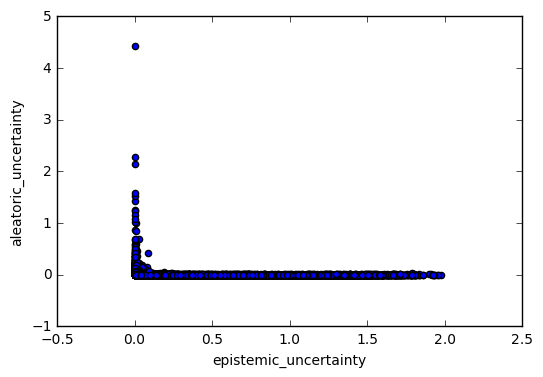

In [28]:
plt.figure()
df.plot(x='epistemic_uncertainty', y='aleatoric_uncertainty', kind='scatter')
plt.show()

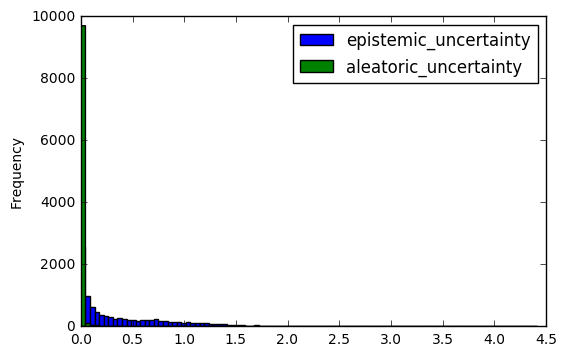

In [29]:
plt.figure()
df.plot.hist(stacked=False, bins=100)
plt.show()

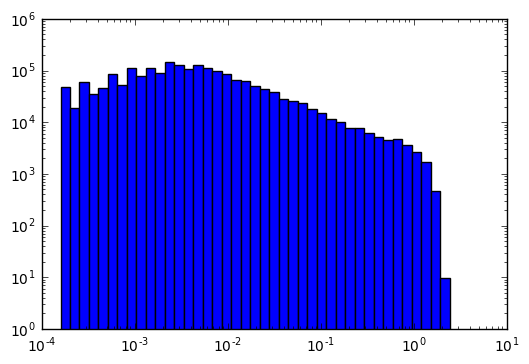

In [30]:
# log-scaled bins
bins = np.logspace(-4., 1.0, 50)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram(df['epistemic_uncertainty'], bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.show()

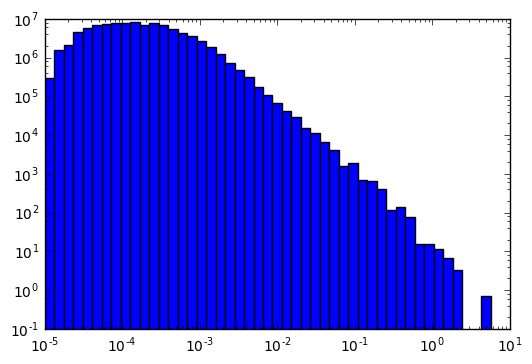

In [31]:
# log-scaled bins
bins = np.logspace(-5., 1.0, 50)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram(df['aleatoric_uncertainty'], bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [32]:
(_, (x_test, y_test)) = test_train_data('cifar10', (197, 197), True)
batch_size = 1
verbose = 0 
epistemic_monte_carlo_simulations = 1
debug = True 
full_model = True
x_train = x_test[0:1]
y_train = y_test[0:1]
encoder = 'resnet50'
dataset = 'cifar10'
model_batch_size = 256
model_epochs = 200
model_monte_carlo_simulations = 100
include_epistemic_uncertainty=False

Resizing images from (32, 32) to (197, 197)
Done resizing train images.
Done resizing test images.


In [33]:
def adjust_gamma(images, gamma=1.0):
  # build a lookup table mapping the pixel values [0, 255] to
  # their adjusted gamma values
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
  
  # apply gamma correction using the lookup table
  return [cv2.LUT(image, table) for image in images]

from keras.applications.resnet50 import preprocess_input
 
def process_images(images, gamma, size=(197,197)):
  return preprocess_input(np.array(adjust_gamma([cv2.resize(image, size) for image in images], gamma), dtype='float64'))

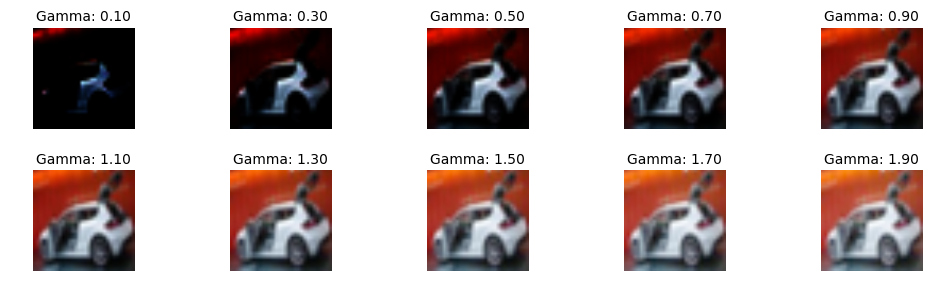

In [36]:
def display_gammas(image, gammas):
  f, axes = plt.subplots(int(len(gammas)/5), 5, figsize=(10, 3))
  f.tight_layout()
  
  axes = np.reshape(axes, -1)
  
  for i in range(len(axes)):
    g_image = adjust_gamma([image], gammas[i])[0]
    axes[i].imshow(g_image)
    axes[i].set_title('Gamma: {0:.2f}'.format(gammas[i]), fontsize=10)
    axes[i].axis('off')
  plt.savefig('blog_images/gammas.png')
  plt.show()
display_gammas(test_images[6], [0.1 + i/5. for i in range(10)])

In [42]:
def predict_with_gamma(gamma):
  data = process_images(test_images[0:128], gamma)
  _, results = predict_on_data(batch_size, verbose, epistemic_monte_carlo_simulations, debug, full_model, 
                x_train, y_train, data, y_test,
                encoder, dataset, model_batch_size, model_epochs, model_monte_carlo_simulations, include_epistemic_uncertainty)
  
  return results

In [43]:
# gamma_predictions = []
# for gamma in range(11):
#   gamma = 0.1 + gamma/5.
#   gamma_predictions.append((gamma, predict_with_gamma(gamma)))

In [ ]:
for gamma, prediction in gamma_predictions:
  print(gamma, np.mean([p['is_correct'] for p in prediction]))
  
gamma_prediction_score = pd.DataFrame(
  [(gamma,np.mean([p['is_correct'] for p in prediction])) for gamma, prediction in gamma_predictions],
  columns=['gamma value', 'accuracy'])
gamma_prediction_score

In [ ]:
# save_dataframe(gamma_prediction_score, 'blog_images', 'gamma_prediction_score', columns=['gamma value', 'accuracy'])

In [ ]:
gamma_aleatoric_uncertainty_df = join_df([(stats_df(prediction, ['aleatoric_uncertainty']), "gamma-{}".format(gamma)) for gamma, prediction in gamma_predictions])
gamma_aleatoric_uncertainty_df

In [ ]:
# save_dataframe(gamma_aleatoric_uncertainty_df, 'blog_images', 'gamma_aleatoric_uncertainty')

In [117]:
from bnn.loss_equations import bayesian_categorical_crossentropy

loss_fn = bayesian_categorical_crossentropy(100, 2)

correct_val = 1.0

X = [x/20 for x in range(-100, 110)]
Y = [0.0001 + y/500 for y in range(0, 1000)]
X, Y = np.meshgrid(X, Y)
predictions = []

for i in range(len(X)):
  pred = []
  for j in range(len(X[0])):
    y = Y[i][j]
    x = X[i][j]
    pred.append([correct_val, x, y])
    
  pred_count = len(pred)
  true = K.variable(np.hstack((np.ones((pred_count, 1)), np.zeros((pred_count, 1)))))
  pred = K.variable(np.array(pred))
  predictions.append(K.eval(loss_fn(true, pred)))
    
    
# predictions_count = len(predictions)
# true = K.variable(np.hstack((np.ones((predictions_count, 1)), np.zeros((predictions_count, 1)))))
# predictions_tensor = K.variable(np.array(predictions))
# z_points = K.eval(loss_fn(true, predictions_tensor))
      
      

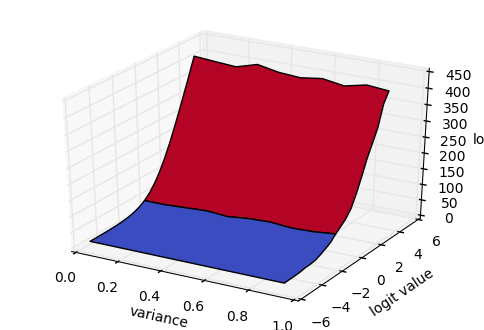

In [115]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, np.array(predictions), cmap=plt.cm.coolwarm)
ax.set_xlabel('variance')
ax.set_ylabel('logit value')
ax.set_zlabel('loss')
plt.show()

In [93]:
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)

X

array([[-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       ..., 
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75]])